# DeepEnsemble
Technically this is combining the ensemble idea with aleatoric error via a Gaussian NLL loss. I think some call the Gaussian NLL loss approach (where you return the $\mu$ and $\sigma$ of a distribution of the output RV) mean-variance estimation (MVE). 

## The dataset: simple linefit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from scripts import train, models, analysis, io

In [3]:
loss_type = 'bnll_loss'
norm = False
# options are 'no_var_loss' or 'var_loss'
# var_loss is a gaussian negative log likelihood option that incorporates a variance term (for aleatoric uncertainty)

## Load linear data from h5
There are multiple noise options, so define sigma first.

In [4]:
DE_TYPE = 'DE'  
noise = 'low'
# model_name will be used to save the model by checkpoint
model_name = DE_TYPE + '_noise_' + noise
BATCH_SIZE = 100

In [5]:
if noise == 'low':
    sigma = 1
if noise == 'medium':
    sigma = 5
if noise == 'high':
    sigma = 10
if noise == 'vhigh':
    sigma = 100
size_df = 1000

In [6]:
loader = io.DataLoader()

In [7]:
data = loader.load_data_h5('linear_sigma_'+str(sigma)+'_size_'+str(size_df))

In [8]:
data

{'inputs': tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
          12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
          24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
          36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
          48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
          60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
          72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
          84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
          96.,  97.,  98.,  99., 100.]),
 'output': tensor([[ 4.3750e+00,  1.3201e+01,  2.2403e+01,  ...,  8.7229e+02,
           8.8232e+02,  8.8982e+02],
         [ 4.1284e+00,  2.8761e+00,  4.8941e+00,  ...,  3.5861e+01,
           3.2522e+01,  3.5881e+01],
         [-8.1434e+00, -8.6568e+00, -5.0547e+00,  ...,  1.5475e+02,
           1.

In [9]:
len_df = len(data['params'][:,0].numpy())
len_x = len(data['inputs'].numpy())
ms_array = np.repeat(data['params'][:,0].numpy(), len_x)
bs_array = np.repeat(data['params'][:,1].numpy(), len_x)
xs_array = np.tile(data['inputs'].numpy(), len_df)
ys_array = np.reshape(data['output'].numpy(), (len_df * len_x))

In [10]:
# combine all of the inputs into one array
# this will be fed into the neural network
inputs = np.array([xs_array, ms_array, bs_array]).T
print(np.shape(inputs))

(101000, 3)


In [11]:
if norm is True:
    print('normalizing')
    # normalize everything before it goes into a network
    inputmin = np.min(inputs, axis = 0)
    inputmax = np.max(inputs, axis = 0)#, axis = 0)
    outputmin = np.min(ys_array)
    outputmax = np.max(ys_array)
    print('input min, max', inputmin, inputmax, 'output min, max', outputmin, outputmax)
    
    model_inputs = (inputs - inputmin) / (inputmax - inputmin)
    model_outputs = (ys_array - outputmin) / (outputmax - outputmin)
else:
    model_inputs = inputs
    model_outputs = ys_array

<Figure size 640x480 with 0 Axes>

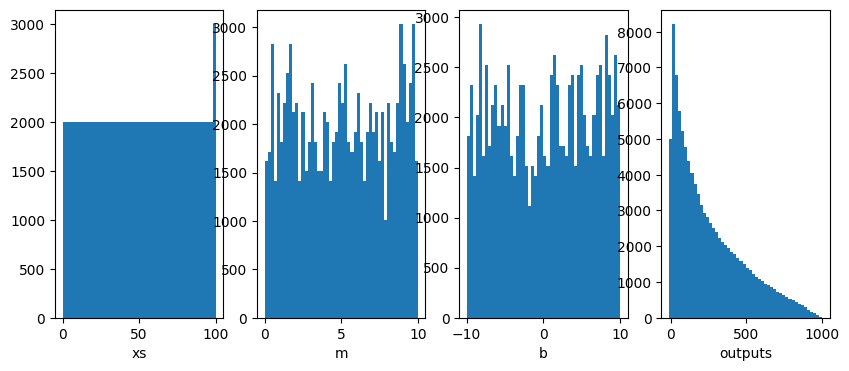

In [12]:
# now plot the histograms of the noramlized values
# to verify it worked
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(model_inputs[:,0], bins=50)
ax0.set_xlabel('xs')
ax1 = fig.add_subplot(142)
ax1.hist(model_inputs[:,1], bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(model_inputs[:,2], bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(model_outputs[:], bins=50)
ax3.set_xlabel('outputs')
plt.show()

In [13]:
# if they are now normalized (0 - 1) they should have the same distribution as before

(90900, 3) (90900,)
(3,)


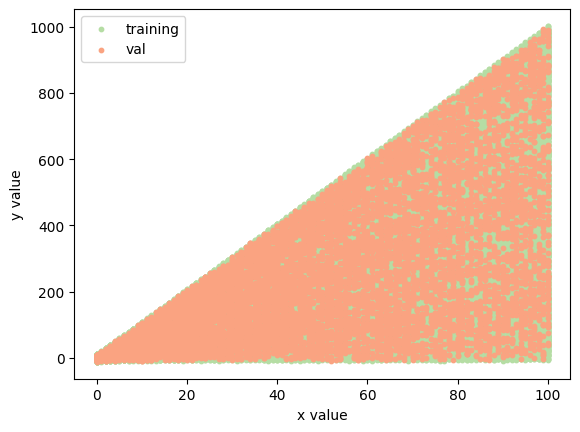

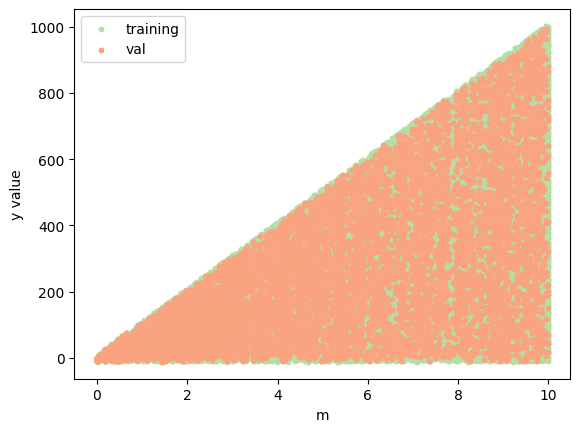

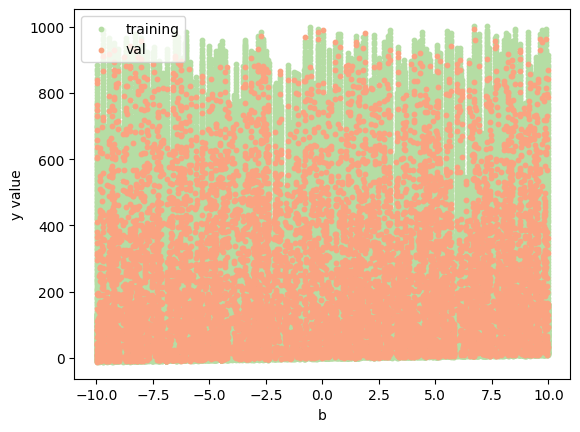

In [14]:
# prepare the training, validation, and test set split:
val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(model_inputs, model_outputs, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train[:,0], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,0], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x value')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,1], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,1], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('m')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,2], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,2], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('b')
plt.ylabel('y value')
plt.show()

In [15]:
# okay now prep the training, validation data
trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)

valData = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('shape of training set', np.shape(x_train))

shape of training set (90900, 3)


In [16]:
# initialize the simple model
INIT_LR = 0.001
print("[INFO] initializing the gal model...")
# set the device we will be using to train the model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, lossFn = models.model_setup_DE(loss_type, DEVICE)
print(model)

[INFO] initializing the gal model...
Sequential(
  (0): Model(
    (model): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (1): MuVarLayer()
)


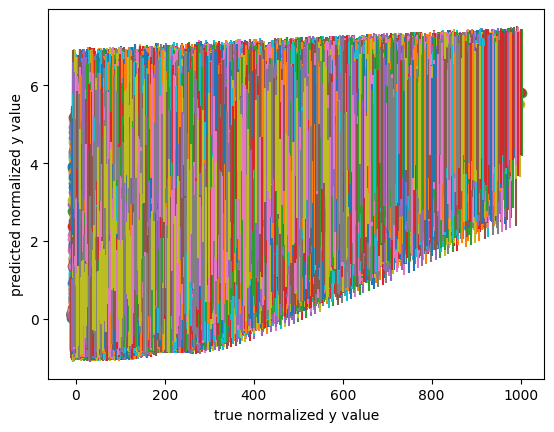

In [17]:
# plot what we're trying to predict
counter = 0
for (x, y) in trainDataLoader: # loading it up in batches
    #print('batch', counter, 'length', len(y))
    # send the input to the device
    (x, y) = (x.to(DEVICE), y.to(DEVICE))
    pred_tensor = model(x)
    pred = pred_tensor.detach().numpy()
    #print(y.shape, pred.shape)
    
    if loss_type == 'no_var_loss':
        plt.scatter(y, pred, linestyle='None')
        #var = torch.ones(5, 1, requires_grad=True)  # homoscedastic
        #print('var', pred[:,1])
        loss = lossFn(pred_tensor, y)
        #print('loss', loss.item())
    else:
        plt.errorbar(y, pred[:,0], yerr = abs(pred[:,1]), linestyle='None')
        plt.scatter(y, pred[:,0], linestyle='None')
        #var = torch.ones(5, 1, requires_grad=True)  # homoscedastic
        #print('var', pred[:,1])
        loss = lossFn(pred_tensor[:,0], y, pred_tensor[:,1]**2, beta = 0.5)
        #print('loss', loss.item())
    
    counter += 1
plt.xlabel('true normalized y value')
plt.ylabel('predicted normalized y value')
#plt.xlim([0,1])
#plt.ylim([0,1])
plt.show()
# Interesting, before the model is trained it basically predicts the mean?

In [ ]:
# option to do this non-verbosely
n_models = 100
INIT_LR = 0.001 # was 0.001
model_ensemble = train.train_DE(trainDataLoader,
             x_val,
             y_val,
             INIT_LR,
             DEVICE,
             loss_type,
             n_models,
             model_name,
             BETA='linear_decrease',#was 0.5
             EPOCHS=100,
             path_to_model="../models/",
             save_all_checkpoints=False,
             save_final_checkpoint=True,
             plot=False,
             savefig=True,
             verbose=False
             )

model 0
model 1
model 2
model 3
model 4
model 5
model 6
model 7
model 8
model 9
model 10
model 11
model 12
model 13
model 14
model 15
model 16
model 17
model 18
model 19
model 20
model 21
model 22
model 23
model 24
model 25
model 26
model 27
model 28
model 29
model 30
model 31
model 32
model 33
model 34
model 35
model 36
model 37
model 38
model 39
model 40
model 41
model 42
model 43
model 44
model 45
model 46
model 47
model 48
model 49
model 50
model 51
model 52
model 53
model 54
model 55
model 56
model 57
model 58
model 59
model 60
model 61
model 62
model 63
model 64
model 65
model 66
model 67
model 68
model 69
model 70
model 71
model 72
model 73
model 74
model 75
model 76
model 77
model 78
model 79


# Everything that follows is old
~~~~~*******~~~~~~

In [ ]:
plt.scatter(range(n_models), mse_list)
plt.title(model_name + r' $\beta = 0.5$')
plt.ylabel('MSE loss')
plt.xlabel('n_models')
plt.show()

In [ ]:
# save the mse list
np.save('MSE_beta_0.5_100_epochs_100_models_softplus.npy', mse_list)

## Test the model
To run it through it's paces, draw and one set of (m, b) values and run it through just one of the above trained models from the ensemble. This will work even if you only train one.

In [ ]:
m_true = np.repeat(1, len(x_data))
b_true = np.repeat(5, len(x_data))


thetas_1d_true = np.array([x_data, m_true, b_true]).T
y_true = simulator([m_true[0], b_true[0]])
y_true_no_noise = simulator_no_noise([m_true[0], b_true[0]])
# now use one of the NNs to make a prediction
model = model_ensemble[0]
model.eval()
# first, normalize the x value using the xmin and xmax before
'''
norm_inputs = (inputs - inputmin) / (inputmax - inputmin)
norm_outputs = (ys - outputmin) / (outputmax - outputmin)
'''

if norm == 'True':
    norm_thetas = (thetas_1d_true - inputmin) / (inputmax - inputmin)
    
    y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
    # now un-normalize this so you can plot it
    if loss_type == 'var_loss':
        y_pred = (y_norm_pred[:,0]) * (outputmax - outputmin) + outputmin
        y_pred_sigma = abs((y_norm_pred[:,1]) * (outputmax - outputmin) + outputmin)
    else:
        y_pred = (y_norm_pred) * (outputmax - outputmin) + outputmin
        y_pred_sigma = 0
else:
    y_notnorm_pred = model(torch.Tensor(thetas_1d_true)).detach().numpy()
    if loss_type == 'var_loss':
        y_pred = y_notnorm_pred[:,0]
        y_pred_sigma = abs(y_notnorm_pred[:,1])
    else:
        y_pred = y_notnorm_pred
        y_pred_sigma = 0
    
    

### Aleatoric Error
Aleatoric error can be calculated individually for each model. It is defined using the sigma output from each individual NN.


In [ ]:
# plot
plt.clf()
plt.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
plt.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.5)
plt.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072')

if loss_type == 'var_loss':
    plt.errorbar(x_data, y_pred, yerr = y_pred_sigma, label = r'NN prediction $u_{al}$', color = '#F7A072')
plt.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
plt.title('Aleatoric Error (MVE)')
plt.show()


### Aleatoric error can also be defined from the combination of NNs
$\sigma_{al} = \sqrt{\frac{1}{N}\sum_{n=1}^N \sigma_i^2} = \sqrt{mean(\sigma_i^2)}$

It is the mean of the predicted $\sigma_i$ values from each network.

### Epistemic error is also defined from the ensemble
$\sigma_{ep} = \sqrt{\frac{1}{N}\sum_{n=1}^N\mu_i^2 - mean(\mu_i)^2} = stdev(\mu_i)$

It is the standard deviation of the predicted values $\mu_i$ from each network.

### Plot aleatoric and epistemic error for each model and for the ensemble

In [ ]:
color_list = ['#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360']

# first plot the true values
plt.clf()
plt.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
plt.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.5)


y_pred_list = []
y_sigma_list = []

for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    if norm == 'True':
        y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
        # now un-normalize this so you can plot it
        if loss_type == 'var_loss':
            y_pred = (y_norm_pred[:,0]) * (outputmax - outputmin) + outputmin
            y_pred_sigma = abs((y_norm_pred[:,1]) * (outputmax - outputmin) + outputmin)
        else:
            y_pred = (y_norm_pred) * (outputmax - outputmin) + outputmin
            y_pred_sigma = 0
    else:
        y_notnorm_pred = model(torch.Tensor(thetas_1d_true)).detach().numpy()
        if loss_type == 'var_loss':
            y_pred = y_notnorm_pred[:,0]
            y_pred_sigma = abs(y_notnorm_pred[:,1])
        else:
            y_pred = y_notnorm_pred
            y_pred_sigma = 0
    plt.scatter(x_data, y_pred, label = f'NN prediction {m} aleatoric', color = color_list[m])
    if loss_type == 'var_loss':
        plt.errorbar(x_data, y_pred, yerr = y_pred_sigma, color = color_list[m])
    y_pred_list.append(np.reshape(y_pred, len(x_data)))
    y_sigma_list.append(np.reshape(y_pred_sigma, len(x_data)))
plt.title('Aleatoric Error for each model individually')
plt.legend()
plt.show()

print(np.shape(y_sigma_list), np.shape(y_pred_list))


ensemble_aleatoric_error = np.sqrt(np.mean(np.array(y_sigma_list)**2, axis = 0))
ensemble_epistemic_error = np.std(y_pred_list, axis = 0)

plt.clf()
plt.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
plt.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.5)

plt.fill_between(x_data,
                 np.mean(y_pred_list, axis = 0) - ensemble_aleatoric_error,
                 np.mean(y_pred_list, axis = 0) + ensemble_aleatoric_error,
                 color = 'grey', alpha = 0.5,
                 label = r'Ensemble Aleatoric 1$\sigma$ uncertainty')
plt.legend()
plt.title('Ensemble Aleatoric Error')
plt.show()

plt.clf()
plt.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
plt.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.5)

plt.fill_between(x_data,
                 np.mean(y_pred_list, axis = 0) - ensemble_epistemic_error,
                 np.mean(y_pred_list, axis = 0) + ensemble_epistemic_error,
                 color = 'grey', alpha = 0.5,
                 label = r'Ensemble Epistemic 1$\sigma$ uncertainty')
plt.legend()
plt.title('Ensemble Epistemic Error')
plt.show()
                 
                 
